In [1]:
from fastMONAI.vision_all import *

In [2]:
STUDY_DIR = "/home/yw4196/Snapshot_brain_nii"
df = pd.read_csv('Snapshot_tidy_brain.csv')
df

,patients,"Sex (1=M, 2=F)",Age (years),SDMT,images
0,9001,2,35,35,/home/yw4196/Snapshot_brain_nii/9001_brain.nii.gz
1,9003,2,53,56,/home/yw4196/Snapshot_brain_nii/9003_brain.nii.gz
2,9004,2,52,54,/home/yw4196/Snapshot_brain_nii/9004_brain.nii.gz
3,9005,1,37,31,/home/yw4196/Snapshot_brain_nii/9005_brain.nii.gz
4,9006,2,39,38,/home/yw4196/Snapshot_brain_nii/9006_brain.nii.gz
5,9007,2,54,50,/home/yw4196/Snapshot_brain_nii/9007_brain.nii.gz
6,9008,2,48,52,/home/yw4196/Snapshot_brain_nii/9008_brain.nii.gz
7,9009,2,50,23,/home/yw4196/Snapshot_brain_nii/9009_brain.nii.gz
8,9016,2,54,69,/home/yw4196/Snapshot_brain_nii/9016_brain.nii.gz
9,9018,2,56,62,/home/yw4196/Snapshot_brain_nii/9018_brain.nii.gz


In [3]:
df.SDMT.min(), df.SDMT.max()

(6, 85)

In [4]:
med_dataset = MedDataset(path=STUDY_DIR, max_workers=1)

In [5]:
data_info_df = med_dataset.summary()

In [6]:
data_info_df

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
0,256,256,256,1.0,1.0,1.0,LIA+,/home/yw4196/Snapshot_brain_nii/9001_brain.nii.gz,49


In [7]:
resample, reorder = med_dataset.suggestion()

In [8]:
bs=2
in_shape = [1, 256, 256, 256]

In [9]:
item_tfms = [ZNormalization(), PadOrCrop(in_shape[1:]), RandomAffine(scales=0, degrees=5, isotropic=False)] 

In [10]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), RegressionBlock), 
                      splitter=RandomSplitter(seed=32),
                      get_x=ColReader('images'),
                      get_y=ColReader('SDMT'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [11]:
dls = dblock.dataloaders(df, bs=bs)

In [12]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(35, 8)

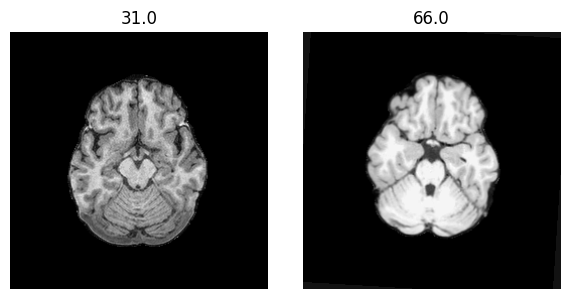

In [13]:
dls.show_batch(anatomical_plane=1)

# Create CNN model

In [14]:
from monai.networks.nets import Regressor
model = Regressor(in_shape=[1, 256, 256, 256], out_shape=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), kernel_size=3, num_res_units=2)

loss_func = L1LossFlat()


In [15]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

GPU is available


In [16]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[mae])

learn.summary()


Regressor (Input shape: 2 x 1 x 256 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 16 x 128 x 128  
Conv3d                                    448        True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    6928       True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    448        True      
____________________________________________________________________________
                     2 x 32 x 64 x 64 x  
Conv3d                                    13856      True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    27680      True      
InstanceNorm3d        

SuggestedLRs(valley=9.120108734350652e-05)

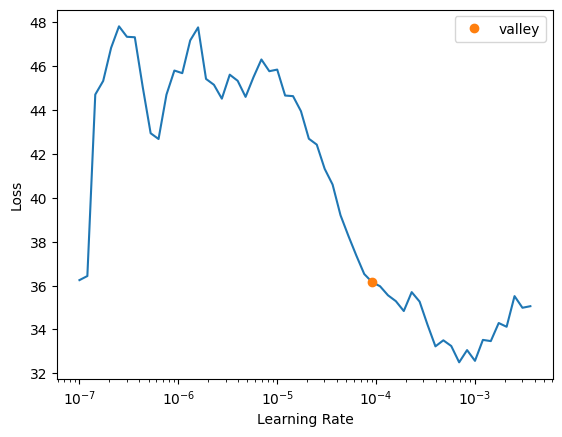

In [17]:
learn.lr_find()

In [18]:


lr = 10e-4

learn.fit_one_cycle(10)



epoch,train_loss,valid_loss,mae,time
0,25.726385,5.656917,5.656917,00:33
1,26.033415,33.824287,33.824287,00:44
2,25.627085,62.870464,62.870464,00:44
3,28.931841,6.678043,6.678043,00:40
4,25.782154,18.191393,18.191393,00:37
5,24.014378,28.718941,28.718941,00:33
6,22.169386,9.893873,9.893873,00:32
7,19.817636,20.241707,20.241707,00:33
8,18.428041,5.540708,5.540708,00:36
9,16.626886,5.445403,5.445403,00:35


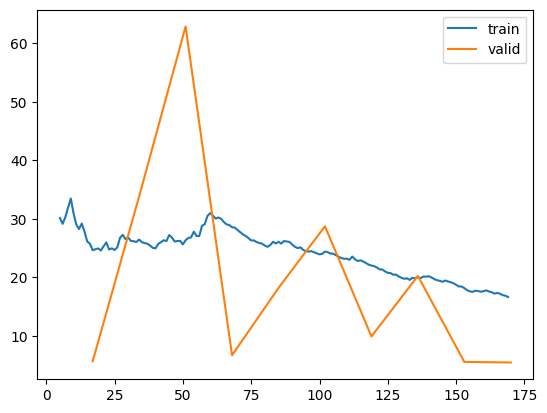

In [19]:
learn.recorder.plot_loss()

In [20]:
learn.save('model-brainSDMT_seg'); 

# Inference

In [17]:
learn.load('model-brainSDMT_seg'); 

In [18]:
interp = Interpretation.from_learner(learn)

In [22]:
interp.top_losses(8)

(TensorBase([16.7107,  8.8395,  7.8096,  3.8458,  3.3508,  1.3943,  1.0673,
              0.5452]),
 TensorBase([5, 6, 4, 2, 3, 1, 0, 7]))

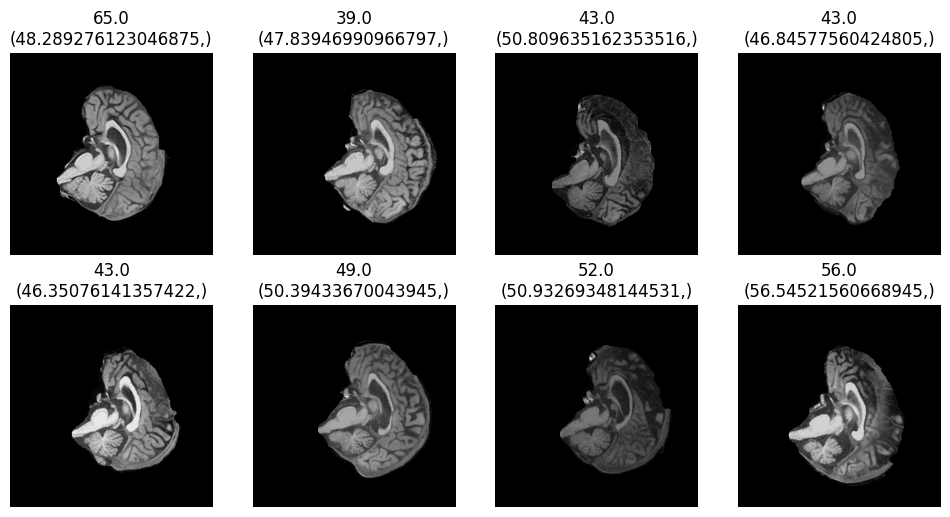

In [19]:
interp.show_results(interp.top_losses(8)[1])